# Lição FastAI 4

Nesta lição o Jeremy ensina como criar um modelo para processamento de linguagem natural. Esse processamento tem como objetivo pegar uma frase e analisar, permitindo dessa forma o computador fazer frazes, analizar o humor, organizar documentos, dentre outras coisas.

Com objetivo de treinar os conceitos passados na aula irei utilizar de um dataset disponibilizado no Kaggle. Foi aberta uma competição com objetivo de analizar tweets e conseguir classificar se o tweet se trata de um desastre ou não.
Para iniciarmos o desenvolvimento teremos que importar uma série de bibliotecas e também o Dataset em si.

In [1]:
!pip install evaluate
import evaluate
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from fastcore.all import *
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
path = Path('../input/nlp-getting-started')
! pip install -q datasets
!ls {path}

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
sample_submission.csv  test.csv  train.csv


Após importado o Dataset da competição já conseguimos utilizar os dados disponibilizados. Basta usar o Pandas para pegar o arquivo csv e transformar em dados alteraveisl.

Podemos ver que a competição disponibiliza uma série de informações como localização, texto, keyword e target que indica se aquele tweet se refere a um desastre de fato ou não.

In [2]:
df = pd.read_csv(path/'train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Para vizualizarmos melhor as informações utilizamos o describe, essa funcionalidade ira da informações gerais sobre os dados. Aqui podemos ver que a palavras que mais aparecem, locais e textos.

In [3]:
df.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


O próximo passo é escolher o modelo, como nunca utilizei um modelo com a finalidade de processar linguagem natural optei pelo modelo sugerido na aula, o deberta versão 3.


In [4]:
model_nm = 'microsoft/deberta-v3-small'

Após pegar o modelo iremos definir o input que o modelo ira receber, durante a aula o Jeremy sugere pegar algumas colunas do seu Dataset e criar uma string, porém ao fazer isso com os dados fornecidos na competição obtive um péssimo desempenho do modelo, então optei por deixar o modelo analizar apenas o texto obtendo dessa forma uma precisão maior.

In [5]:
df['input'] = 'TEXT: ' + df.text
df = df.astype({'target':'float'})

Agora iremos criar o Dataset dos dados fornecidos.

In [6]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input'],
    num_rows: 7613
})

Decidido o Input iremos criar o tokenizador para o nosso Dataset. Essa parte é essencial pois o modelo não espera receber palavras, ele ira analizar números e esses números são gerados primeiro pela tokenização dos dados e em seguida pela numeração desses dados, dando para cada token um número.

O código abaixo irá importar um tokenizador automático, que recebe o modelo.

In [7]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Criado o tokenizador o próximo passo é gerar os tokens de fato, esse passo é feito com a criação de uma função que ira passar por todos os textos criando um token.

Um importante passo é definir a coluna target, que possui as definições do tweet, como label pois é essa coluna que o modelo ira utilizar na hora do treinamento.

In [8]:
def tok_func(x): 
    return tokz(x["input"])
tok_ds = ds.map(tok_func, batched=True)
tok_ds = tok_ds.rename_columns({'target':'labels'})

  0%|          | 0/8 [00:00<?, ?ba/s]

Abaixo podemos vizualizar melhor como será o input que criamos com o texto e os id dos tokens gerados.

In [9]:
row = tok_ds[0]
row['input'], row['input_ids']


('TEXT: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 [1,
  54453,
  294,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

Agora devemos criar o Dataset para os dados de treinamento, esse passo será basicamente com o mesmo processo feito anteriormente.

In [10]:
eval_df = pd.read_csv(path/'test.csv')
eval_df['input'] = eval_df.text
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

eval_df.describe()

  0%|          | 0/4 [00:00<?, ?ba/s]

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


Outro importante parametro que o modelo recebe é o Dataset de Dicionário, assim iremos utilizar 25% dos dados para fazer a validação e 75% no treino do modelo

In [11]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

Na liçao ele utiliza o grau de correlação Pearson, porém no caso da competição usaremos o F1, apesar disso segue uma breve explicação do Pearson tirada da Wikipedia. 

> In statistics, the Pearson correlation coefficient (PCC, pronounced /ˈpɪərsən/) ― also known as Pearson's r, the Pearson product-moment correlation coefficient (PPMCC), the bivariate correlation,[1] or colloquially simply as the correlation coefficient[2] ― is a measure of linear correlation between two sets of data. It is the ratio between the covariance of two variables and the product of their standard deviations; thus, it is essentially a normalized measurement of the covariance, such that the result always has a value between −1 and 1

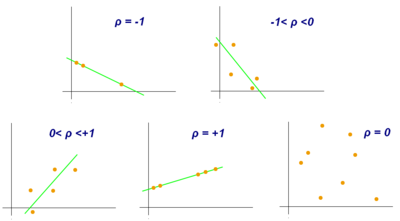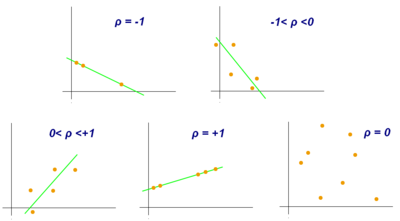

Apesar disso, nessa competição foi indicado para utilizar da métrica F1, essa métrica é disponibilizada pelo HugginFaces na funcionalidade evaluate. Então utilizando dessa funcionalidade criaremos a função que ira gerar a métrica usada no modelo

> Na análise estatística da classificação binária, o F-score ou F-measure é uma medida da precisão de um teste. É calculado a partir da precisão e recall do teste, onde a precisão é o número de resultados verdadeiros positivos dividido pelo número de todos os resultados positivos, inclusive aqueles não identificados corretamente, e o recall é o número de resultados verdadeiros positivos dividido pelo número de todas as amostras que deveriam ter sido identificadas como positivas. A precisão também é conhecida como valor preditivo positivo, e a revocação também é conhecida como sensibilidade na classificação binária diagnóstica. (Texto retirado da Wikipedia)

**O valor mais alto possível de um F-score é 1,0, indicando precisão e recall perfeitos, e o menor valor possível é 0, se a precisão ou o recall forem zero**

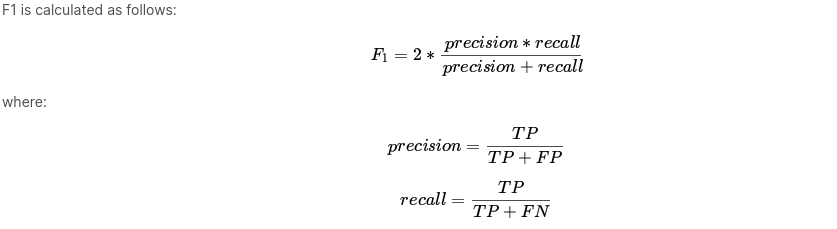

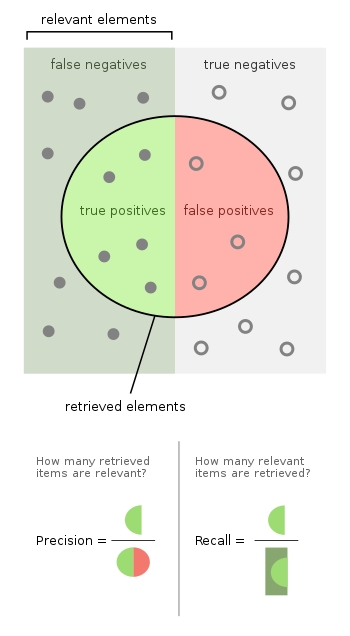

**Texto traduzido da Wikipedia**

In [12]:
def metrics(eval_pred):
    metric = evaluate.load('f1')
    logits, labels = eval_pred
    predictions = np.clip(logits, 0, 1)
    return metric.compute(predictions=predictions, references=labels)

**In Math, Logit is a function that maps probabilities ([0, 1]) to R ((-inf, inf))**

Agora decidiremos o bachsize(128), as epochs(4) e o lerningrate(8e-5). Esses valores foram utilizados seguindo a aula e eu não cheguei a tentar decidir quais seriam os melhores valores para o modelo sugerido.

In [13]:
from transformers import TrainingArguments,Trainer
bs = 128
epochs = 4
lr = 8e-5

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Aqui decidimos os argumentos que segue basicamente um padrão. Em seguida criamos o modelo com a função AutoModelForSequenceClassification que irá ter apenas um label. E por fim o treinamento de fato, esse passo tem como objetivo unir o modelo criado com o Dataset melhorando sua capacidade de classificação.



**Bem parecido com o learner do FastAI**

In [25]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none', logging_steps=50)



model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=metrics)
trainer.train();

PyTorch: setting up devices
loading configuration file https://huggingface.co/microsoft/deberta-v3-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/8e0c12a7672d1d36f647c86e5fc3a911f189d8704e2bc94dde4a1ffe38f648fa.9df96bac06c2c492bc77ad040068f903c93beec14607428f25bf9081644ad0da
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-small",
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  

Epoch,Training Loss,Validation Loss,F1
1,No log,0.156409,0.000000
2,No log,0.124290,0.379447
3,0.247000,0.123996,0.600000
4,0.247000,0.129903,0.687648


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, id, input, keyword, location. If text, id, input, keyword, location are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 512
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, id, input, keyword, location. If text, id, input, keyword, location are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.

Podemos ver que consegui chegar num grau F1 de 70%. Hora de testar o modelo. 

In [15]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, id, input, keyword, location. If text, id, input, keyword, location are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 512


array([[1.07888937],
       [1.0361191 ],
       [1.0531069 ],
       ...,
       [1.11478257],
       [1.06862664],
       [1.02962077]])

Podemos ver que o valor das previsões está acima de 1.0 o que indica algum erro no modelo. Infelizmente apesar de pesquisar bastante o assunto não consegui corrigir o problema com as técnicas apresentadas na aula, nem explicar o porque desse erro no meu modelo. Porém para fins de curiosidade segue o valor da previsão de um tweet aleatório e o seu texto de fato.

In [16]:
preds = trainer.predict([eval_ds[500]]).predictions.astype(float)
preds[0][0]

***** Running Prediction *****
  Num examples = 1
  Batch size = 512
The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, id, input, keyword, location. If text, id, input, keyword, location are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.


1.0942972898483276

In [17]:
eval_ds[500]

{'id': 1635,
 'keyword': 'bombing',
 'location': 'Tokyo JAPAN',
 'text': '#Hiroshima marks 70th anniversary of atomic bombing ( via NHK WORLD News) http://t.co/qGWoyNJLY8',
 'input': '#Hiroshima marks 70th anniversary of atomic bombing ( via NHK WORLD News) http://t.co/qGWoyNJLY8',
 'input_ids': [1,
  953,
  1773,
  17202,
  28991,
  4158,
  2284,
  474,
  4663,
  265,
  15079,
  13854,
  287,
  1096,
  87887,
  24189,
  1864,
  285,
  1871,
  294,
  320,
  320,
  297,
  260,
  1902,
  320,
  4553,
  32470,
  21677,
  29593,
  7954,
  804,
  2],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

O próximo passo seria o de exportar o modelo, porém tentei sem sucesso essa fase do processo. Apesar disso a ideia era criar um espaço em que o usuário escolheria um dentre os exemplos disponibilizados e o modelo indicaria se de fato era um desastre ou não. Template disponível em: https://huggingface.co/spaces/DanielViniciusAlves/AM_Lesson_3/upload/main?logs=true

In [20]:
!pip install huggingface_hub

from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash 
!sudo apt-get install git-lfs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected operating system as Ubuntu/focal.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.0.9
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can e

In [23]:
trainer.push_to_hub("twitter")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/DanielViniciusAlves/outputs into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Saving model checkpoint to outputs
Configuration saved in outputs/config.json
Model weights saved in outputs/pytorch_model.bin
tokenizer config file saved in outputs/tokenizer_config.json
Special tokens file saved in outputs/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/541M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.17k/3.17k [00:00<?, ?B/s]

Upload file spm.model:   1%|1         | 32.0k/2.35M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DanielViniciusAlves/outputs
   38183a7..91e310a  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'F1', 'type': 'f1', 'value': 0.7009992313604919}]}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/DanielViniciusAlves/outputs
   91e310a..450a2d2  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/DanielViniciusAlves/outputs/commit/91e310a470f27a7a02589fff05fa14b4dfde1b22'